In [1]:
# !pip install git+git://github.com/StochSS/sciope.git@master
import numpy as np
import sys
sys.path.insert(1, '/home/smatthe2/sciope')
sys.path.insert(1, '/home/smatthe2/GillesPy2')
import sciope
import gillespy2
from gillespy2 import Model, Species, Parameter, Reaction, Event, \
                      EventTrigger, EventAssignment, Results
from gillespy2 import ODECSolver, ODESolver, SSACSolver, TauHybridSolver, TauHybridCSolver

import matplotlib.pyplot as plt

# devils_2stage_inference

In [2]:
variables = {
    "juvenile_concentration": 0.467,
    "infected_concentration": 5e-5,
    "birth_rate": 0.055,
    "maturity_rate": 0.04267,
    "infection_rate_infected": 2e-05,
    "infection_rate_diseased": 3e-05,
    "incubation": 22.6,
    "progression": 12,
    "death_rate_juvenile": 0.006,
    "death_rate_susceptible": 0.02335,
    "death_rate_over_population": 2.3e-7,
    "death_rate_infected": 0.03,
    "death_rate_diseased": 0.048,
    "DFTD_start": 40
}
variables_orig = variables.copy()

In [3]:
import pandas as pd

# pop_data = pd.read_csv('../year_data/devil_data_v2.csv')
pop_data = pd.read_csv('month_data/Devils_Dataset__Population_1985-2020.csv')

devil_pop = np.array(pop_data['Population'].iloc[:].values)
init_devils_pop = devil_pop[40]
# dftd_pop = .1*init_devils_pop

# model.listOfParameters['K'].expression = max(devil_pop)*1.3

# model.listOfSpecies['Devils'].initial_value = init_devils_pop
# model.listOfSpecies['I'].initial_value = round(init_devils_pop*.001)  # This will be overwritten by variables later
# model.listOfSpecies['S'].initial_value = round(init_devils_pop*.999)

obs = np.vstack([devil_pop]).reshape(1, 1, -1)
print(devil_pop)

[34615.70418 34615.70418 34741.36901 34867.03384 35055.53109 35244.02834
 35432.52558 35621.02283 35872.35249 35998.01732 36186.51457 36375.01181
 36563.50906 36752.0063  36877.67114 37129.0008  37254.66563 37443.16287
 37631.66012 37945.8222  38134.31944 38259.98427 38448.48152 38636.97877
 38888.30843 39076.80567 39265.30292 39453.80017 39705.12983 39956.45949
 40333.45398 40459.11881 40773.28089 40961.77814 41150.27538 41338.77263
 41590.10229 41841.43195 41967.09678 42155.59403 42281.25886 42721.08577
 42909.58301 43035.24784 43286.57751 43412.24234 43663.572   43789.23683
 43977.73407 44040.56649 44166.23132 44229.06374 44354.72857 44417.56098
 44480.3934  44543.22581 44668.89064 44668.89064 44794.55547 44794.55547
 44920.22031 44983.05272 45108.71755 45422.87963 45611.37688 45737.04171
 45862.70654 46051.20378 46239.70103 46365.36586 46428.19828 46616.69552
 46805.19277 46930.8576  47370.68451 47559.18175 47810.51141 47936.17624
 48187.50591 48376.00315 48501.66798 48690.16523 48

In [4]:
class Devils2Stage(Model):
    def __init__(self, values=variables, events=None):
        Model.__init__(self, name="Devils DFTD 2-Stage Infection")
        self.volume = 1

        # Parameters
        birth_rate = Parameter(name="birth_rate", expression=values['birth_rate'])
        death_rate_juvenile = Parameter(name="death_rate_juvenile", expression=values['death_rate_juvenile'])
        maturity_rate = Parameter(name="maturity_rate", expression=values['maturity_rate'])
        death_rate_susceptible = Parameter(
            name="death_rate_susceptible", expression=values['death_rate_susceptible']
        )
        death_rate_over_population = Parameter(
            name="death_rate_over_population", expression=values['death_rate_over_population']
        )
        infection_rate_infected = Parameter(
            name="infection_rate_infected", expression=values['infection_rate_infected']
        )
        infection_rate_diseased = Parameter(
            name="infection_rate_diseased", expression=values['infection_rate_diseased']
        )
        incubation = Parameter(name="incubation", expression=values['incubation'])
        death_rate_infected = Parameter(name="death_rate_infected", expression=values['death_rate_infected'])
        progression = Parameter(name="progression", expression=values['progression'])
        death_rate_diseased = Parameter(name="death_rate_diseased", expression=values['death_rate_diseased'])
        DFTD_start = Parameter(name="DFTD_start", expression=values['DFTD_start'])
        
        self.add_parameter([birth_rate, death_rate_juvenile, maturity_rate, death_rate_susceptible,
                            death_rate_over_population, infection_rate_infected, infection_rate_diseased,
                            incubation, death_rate_infected, progression, death_rate_diseased, DFTD_start])

        # Variables (initial values adjusted to observed data)
        initial_devil_population  = int(devil_pop[0])
        
        Juvenile = Species(
            name="Juvenile", mode="continuous",
            initial_value=round(initial_devil_population * values['juvenile_concentration'])
        )
        Susceptible = Species(
            name="Susceptible", mode="continuous",
            initial_value=round(initial_devil_population * (1 - values['juvenile_concentration']))
        )
        Exposed = Species(name="Exposed", initial_value=0, mode="continuous")
        Infected = Species(name="Infected", initial_value=0, mode="continuous")
        Diseased = Species(name="Diseased", initial_value=0, mode="continuous")
        Devils = Species(name="Devils", initial_value=initial_devil_population, mode="continuous")
        self.add_species([Juvenile, Susceptible, Exposed, Infected, Diseased, Devils])

        # Reactions
        Birth = Reaction(name="Birth",
            reactants={}, products={'Juvenile': 1, 'Devils': 1},
            propensity_function="birth_rate * (Susceptible + Exposed + Infected)"
        )
        Mature = Reaction(name="Mature",
            reactants={'Juvenile': 1}, products={'Susceptible': 1},
            propensity_function="Juvenile * maturity_rate"
        )
        self.add_reaction([Birth, Mature])
        
        Death_Juvenile = Reaction(name="Death_Juvenile",
            reactants={'Juvenile': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_juvenile * Juvenile"
        )
        Death_Juvenile2 = Reaction(name="Death_Juvenile2",
            reactants={'Juvenile': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Juvenile * (Devils-1)"
        )
        Death_Susceptible = Reaction(name="Death_Susceptible",
            reactants={'Susceptible': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_susceptible * Susceptible"
        )
        Death_Susceptible2 = Reaction(name="Death_Susceptible2",
            reactants={'Susceptible': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Susceptible * (Devils-1)"
        )
        Death_Infected = Reaction(name="Death_Infected",
            reactants={'Infected': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_infected * Infected"
        )
        Death_Infected2 = Reaction(name="Death_Infected2",
            reactants={'Infected': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Infected * (Devils-1)"
        )
        Death_Exposed = Reaction(name="Death_Exposed",
            reactants={'Devils': 1, 'Exposed': 1}, products={},
            propensity_function="death_rate_susceptible * Exposed"
        )
        Death_Exposed2 = Reaction(name="Death_Exposed2",
            reactants={'Devils': 1, 'Exposed': 1}, products={},
            propensity_function="death_rate_over_population * Exposed * (Devils - 1)"
        )
        Death_Diseased = Reaction(name="Death_Diseased",
            reactants={'Diseased': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_diseased * Diseased"
        )
        Death_Diseased2 = Reaction(name="Death_Diseased2",
            reactants={'Diseased': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Diseased * (Devils - 1)"
        )
        self.add_reaction([Death_Juvenile, Death_Susceptible, Death_Exposed, Death_Infected, Death_Diseased,
                           Death_Juvenile2, Death_Susceptible2, Death_Exposed2, Death_Infected2, Death_Diseased2])
        
        
        TransmissionI = Reaction(name="TransmissionI",
            reactants={'Susceptible': 1, 'Infected': 1}, products={'Exposed': 1, 'Infected':1},
            propensity_function="infection_rate_infected * Susceptible * Infected"
        )
        TransmissionD = Reaction(name="TransmissionD",
            reactants={'Susceptible': 1, 'Diseased': 1}, products={'Exposed': 1, 'Diseased':1},
            propensity_function="infection_rate_diseased * Susceptible * Diseased"
        )
        DFTD_Stage1 = Reaction(name="DFTD_Stage1",
            reactants={'Exposed': 1}, products={'Infected': 1},
            propensity_function="Exposed / incubation"
        )
        DFTD_Stage2 = Reaction(name="DFTD_Stage2",
            reactants={'Infected': 1}, products={'Diseased': 1},
            propensity_function="Infected / progression"
        )
        self.add_reaction([TransmissionI, TransmissionD, DFTD_Stage1, DFTD_Stage2])

        # Events
        
        et = EventTrigger(expression='t>=DFTD_start')
        ea1 = EventAssignment(variable=Susceptible, expression='Susceptible-1')
        ea2 = EventAssignment(variable=Infected, expression='1')
        ea3 = EventAssignment(variable=DFTD_start, expression='1000000')
        introduce_dftd = Event(name='introduce_dftd', trigger=et, assignments=[ea1, ea2])
        self.add_event(introduce_dftd)
        if events is not None:
            self.add_event(events)

        # Timespan
        self.timespan(np.arange(0, 421, 1)) # month data tspan
        
#     def run(self, with_pr=True, **kwargs):
#         if not with_pr:
#             return super().run(**kwargs)
        
#         self.resolve_parameters()
#         t = int(self.listOfParameters['DFTD_start'].value)
#         res1 = super().run(**kwargs, t=t)
        
#         if not "variables" in kwargs.keys():
#             kwargs['variables'] = {}
#         kwargs['variables']['Infected'] = "1"
#         kwargs['variables']['Susceptible'] = f"{int(res1[0]['Susceptible'][-1] - 1)}"
        
#         res2 = super().run(resume=res1, **kwargs)
#         for species in self.listOfSpecies.keys():
#             res2[0][species] = res2[0][species]
        
#         return res2

In [5]:
model = Devils2Stage()
print(model)

Devils DFTD 2-Stage Infection

**********
Species
**********

Devils: 34615.0
Diseased: 0.0
Exposed: 0.0
Infected: 0.0
Juvenile: 16165.0
Susceptible: 18450.0

**********
Parameters
**********

DFTD_start: 40
birth_rate: 0.055
death_rate_diseased: 0.048
death_rate_infected: 0.03
death_rate_juvenile: 0.006
death_rate_over_population: 2.3e-07
death_rate_susceptible: 0.02335
incubation: 22.6
infection_rate_diseased: 3e-05
infection_rate_infected: 2e-05
maturity_rate: 0.04267
progression: 12

**********
Reactions
**********

Birth
	Products
		Juvenile: 1
		Devils: 1
	Propensity Function: (birth_rate*((Susceptible+Exposed)+Infected))
DFTD_Stage1
	Reactants
		Exposed: 1
	Products
		Infected: 1
	Propensity Function: (Exposed/incubation)
DFTD_Stage2
	Reactants
		Infected: 1
	Products
		Diseased: 1
	Propensity Function: (Infected/progression)
Death_Diseased
	Reactants
		Diseased: 1
		Devils: 1
	Propensity Function: (death_rate_diseased*Diseased)
Death_Diseased2
	Reactants
		Diseased: 1
		Devils:

# Model Inference

In [6]:
%load_ext autoreload
%autoreload 2

from tsfresh.feature_extraction.settings import MinimalFCParameters
from sciope.utilities.priors import uniform_prior
from sciope.utilities.summarystats import auto_tsfresh
from sciope.utilities.distancefunctions import naive_squared, euclidean, manhattan
from sciope.inference.abc_inference import ABC
from sciope.inference.smc_abc import SMCABC
from sciope.utilities.epsilonselectors import RelativeEpsilonSelector
from sklearn.metrics import mean_absolute_error
import dask
from dask.distributed import Client

## Generate some fixed(observed) data based on default parameters of the model

In [7]:
def configure_simulation():
    solver = TauHybridCSolver(model=model, variable=True)
    kwargs = {
        "solver":solver,
#         "number_of_trajectories":100,
#         "seed":None,
#         "tau_tol":0.03,
#         "integrator_options":{'rtol': 0.001, 'atol': 1e-06}
    }
    return kwargs

In [8]:
kwargs = configure_simulation()

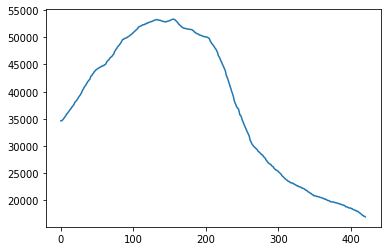

In [9]:
observed_t = 421

plt.plot(range(observed_t), devil_pop) #starting month 40
# plt.plot(model.tspan, dfdt_pop)

In [10]:
solver = TauHybridCSolver(model, variable=True)

In [11]:
results = model.run(solver=solver)

results.plotplotly()

In [12]:
results

[{'time': array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148.

In [13]:
# obs = np.vstack([results['Devils']]).reshape(1, 1, -1)

In [14]:
obs

array([[[34615.70418, 34615.70418, 34741.36901, 34867.03384,
         35055.53109, 35244.02834, 35432.52558, 35621.02283,
         35872.35249, 35998.01732, 36186.51457, 36375.01181,
         36563.50906, 36752.0063 , 36877.67114, 37129.0008 ,
         37254.66563, 37443.16287, 37631.66012, 37945.8222 ,
         38134.31944, 38259.98427, 38448.48152, 38636.97877,
         38888.30843, 39076.80567, 39265.30292, 39453.80017,
         39705.12983, 39956.45949, 40333.45398, 40459.11881,
         40773.28089, 40961.77814, 41150.27538, 41338.77263,
         41590.10229, 41841.43195, 41967.09678, 42155.59403,
         42281.25886, 42721.08577, 42909.58301, 43035.24784,
         43286.57751, 43412.24234, 43663.572  , 43789.23683,
         43977.73407, 44040.56649, 44166.23132, 44229.06374,
         44354.72857, 44417.56098, 44480.3934 , 44543.22581,
         44668.89064, 44668.89064, 44794.55547, 44794.55547,
         44920.22031, 44983.05272, 45108.71755, 45422.87963,
         45611.37688, 45

## Define prior distribution

In [15]:
# take default from mode 1 as reference
default_param = np.array(list(model.listOfParameters.items()))[:, 1]

print(default_param)

parameter_names = []
bound = []
for exp in default_param:
    bound.append(float(exp.expression))
    parameter_names.append(exp.name)

print(parameter_names)
print(bound)
# bound = np.log(bound)
# Set the bounds
bound = np.array(bound)
dmin = np.log(bound * 0.5)
dmax = np.log(bound * 5.0)
# dmin = bound * 0.5
# dmax = bound * 5.0

print(dmin)
print(dmax)
# Here we use uniform prior
uni_prior = uniform_prior.UniformPrior(dmin, dmax)

['DFTD_start', 'birth_rate', 'death_rate_diseased', 'death_rate_infected', 'death_rate_juvenile', 'death_rate_over_population', 'death_rate_susceptible', 'incubation', 'infection_rate_diseased', 'infection_rate_infected', 'maturity_rate', 'progression']
[40.0, 0.055, 0.048, 0.03, 0.006, 2.3e-07, 0.02335, 22.6, 3e-05, 2e-05, 0.04267, 12.0]
[  2.99573227  -3.59356927  -3.72970145  -4.19970508  -5.80914299
 -15.97833371  -4.45030548   2.42480273 -11.10746036 -11.51292546
  -3.84740636   1.79175947]
[  5.29831737  -1.29098418  -1.42711636  -1.89711998  -3.5065579
 -13.67574862  -2.14772038   4.72738782  -8.80487526  -9.21034037
  -1.54482127   4.09434456]


In [16]:
# parameter_names = ['r',    'K',   'L',   'k0']
# lower_bounds =    [.002,   45000, .003,  .06]
# upper_bounds =    [.04,    75000, .04,   .7]
# uni_prior = uniform_prior.UniformPrior(np.array(lower_bounds), np.array(upper_bounds))

## Define simulator

In [17]:
def set_model_parameters(params):
    # params - array, need to have the same order as model.listOfParameters
    variables = dict(zip(parameter_names, params))
    return variables

# Here we use the GillesPy2 Solver
def simulator(params, model):
    print('testing params:\n', params)
    params = np.exp(params)
    variables = set_model_parameters(params)
    res = model.run(variables=variables, solver=solver)
#     res = res.to_array()
#     tot_res = np.asarray([x.T for x in res]) # reshape to (N, S, T)
#     # should not contain timepoints
#     tot_res = tot_res[:, 1:, :]
    devils = res['Devils']
#     infected = res['I']

    return np.vstack([devils]).reshape(1, 1, -1)
#     return tot_res

# Wrapper, simulator function to abc should should only take one argument (the parameter point)
def simulator2(x):
    return simulator(x, model=model)

## Define summary statistics and distance function

In [18]:
# Function to generate summary statistics
summ_func = auto_tsfresh.SummariesTSFRESH()

# Distance
ed = euclidean.EuclideanDistance()
mh = manhattan.ManhattanDistance()

## Start local cluster using dask client

In [19]:
c = Client()

## Start abc instance

In [20]:
abc = SMCABC(obs,
                          sim=simulator2,
                          prior_function=uni_prior,
                          summaries_function=summ_func.compute,
                          distance_function=mh
                         )
# abc.compute_fixed_mean(1)

In [21]:
# First compute the fixed(observed) mean
# abc.compute_fixed_mean(chunk_size=2)

In [22]:
max_rounds = 6
eps_selector = RelativeEpsilonSelector(20, max_rounds)
with dask.config.set(schedular="processes", workers=20):
    print(c)
    res = abc.infer(num_samples=100, batch_size=10, chunk_size=1, eps_selector=eps_selector)

<Client: 'tcp://127.0.0.1:45755' processes=4 threads=8, memory=8.14 GB>
Determining initial population using 20
Starting epsilon = 108152694.59621383
Starting epsilon = 43015481.98556825
Starting epsilon = 28000918.19765211
Starting epsilon = 7727894.9591945
Starting epsilon = 5266059.272434691


In [23]:
# mae_inference = mean_absolute_error(bound, abc.results['inferred_parameters'])
res[0]

{'accepted_samples': [array([  5.27700784,  -2.24365101,  -3.4769141 ,  -2.26774696,
          -4.02169082, -13.90130614,  -4.23870496,   3.11403023,
          -9.09421209,  -9.39008996,  -3.20632079,   2.68354212]),
  array([  4.25476207,  -2.86879611,  -1.45829814,  -2.12349764,
          -5.69937082, -15.6333076 ,  -2.7611567 ,   4.6499092 ,
          -9.64276789, -10.35504771,  -2.92648985,   2.82422707]),
  array([  4.84712016,  -3.30993444,  -1.62863161,  -3.81726909,
          -4.14801   , -14.54840695,  -3.52131301,   2.65569967,
          -9.83432875,  -9.64477073,  -2.40867102,   2.50157401]),
  array([  3.03619379,  -1.97854379,  -1.62855114,  -2.43859608,
          -5.4500494 , -15.68941683,  -3.7012442 ,   2.71133856,
         -10.06409526, -11.28811997,  -3.66015886,   3.00506163]),
  array([  5.24952533,  -1.40152468,  -2.05392467,  -2.10716849,
          -3.53506457, -13.85727531,  -3.20409942,   3.77965119,
         -10.19159552, -11.18190545,  -3.82711761,   2.1294027

## Analysis

In [24]:
posterior = np.array(res[0]['accepted_samples'])

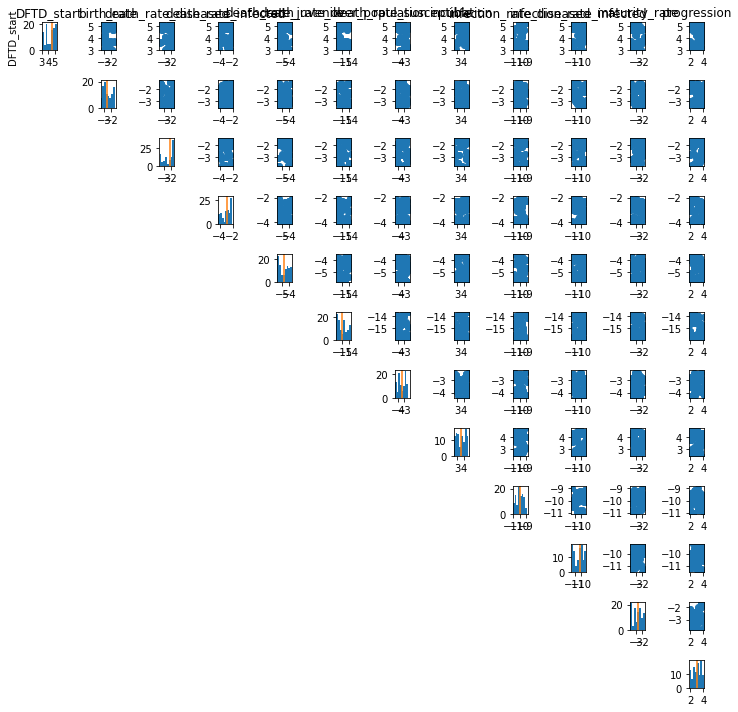

In [25]:
fig, ax = plt.subplots(posterior.shape[1], posterior.shape[1])
for i in range(posterior.shape[1]):
    for j in range(posterior.shape[1]):
        if i > j:
            ax[i,j].axis('off')
        else:
            if i == j:
                ax[i,j].hist(posterior[:,i], bins = 'auto')
                ax[i,j].axvline(np.median(posterior[:,i]), color = 'C1')
                ax[i,j].set_xlim(dmin[i], dmax[i])
            else:
                ax[i,j].scatter(posterior[:,j], posterior[:,i])
                ax[i,j].set_ylim(dmin[i], dmax[i])
                ax[i,j].set_xlim(dmin[j], dmax[j])
    ax[i,0].set_ylabel(parameter_names[i])
    ax[0,i].set_title(parameter_names[i])
fig.set_size_inches(10,10)
fig.tight_layout()

In [26]:
# for i in range(posterior.shape[0]):
#     res = simulator2(posterior[i,:])
#     plt.plot(res[0,:], color = 'C0', alpha = 0.02)
# #     ax[1].plot(res[0,1,:], color = 'C0', alpha = 0.02)
# plt.plot(obs[0,0,:], color = 'black', label = 'Observed Data')
# # ax[1].plot(obs[0,1,:], color = 'black', label = 'Observed Data')
# plt.title("Total Devil Population")
# # ax[1].set_title("Infected")
# plt.legend(loc='best')

In [27]:
# res = simulator2(posterior[10,:])
# print(res)
# plt.plot(res[0,:], color = 'C0', alpha = 0.02)
# #     ax[1].plot(res[0,1,:], color = 'C0', alpha = 0.02)
# plt.plot(obs[0,0,:], color = 'black', label = 'Observed Data')
# # ax[1].plot(obs[0,1,:], color = 'black', label = 'Observed Data')
# plt.title("Total Devil Population")
# # ax[1].set_title("Infected")
# plt.legend(loc='best')

In [28]:
best_index = np.argmin(res[0]['distances'])

In [29]:
res[0]['distances'][best_index]

48110326.32098173

In [30]:
print(posterior[best_index])

[  3.75368154  -2.64609906  -1.4820816   -2.79902594  -5.34392536
 -14.79880002  -3.68193845   3.56823327 -10.5536111  -11.37633363
  -1.70675167   3.7330459 ]


2021-12-13 20:09:58,191 - root - WARNING - Unsupported keyword argument to TauHybridSolver solver: with_pr
2021-12-13 20:09:58,191 - root - WARNING - Unsupported keyword argument to TauHybridSolver solver: with_pr
2021-12-13 20:09:58,196 - root - WARNING - Unsupported keyword argument to TauHybridSolver solver: variables
2021-12-13 20:09:58,196 - root - WARNING - Unsupported keyword argument to TauHybridSolver solver: variables


{'DFTD_start': 42.67791360782606, 'birth_rate': 0.07092735722346137, 'death_rate_diseased': 0.22716433065233038, 'death_rate_infected': 0.06086932420915411, 'death_rate_juvenile': 0.004777082100010128, 'death_rate_over_population': 3.7407855560602573e-07, 'death_rate_susceptible': 0.02517412867015057, 'incubation': 35.453900284220914, 'infection_rate_diseased': 2.609906419257709e-05, 'infection_rate_infected': 1.146360143229596e-05, 'maturity_rate': 0.18145425875456014, 'progression': 41.80625189421796}


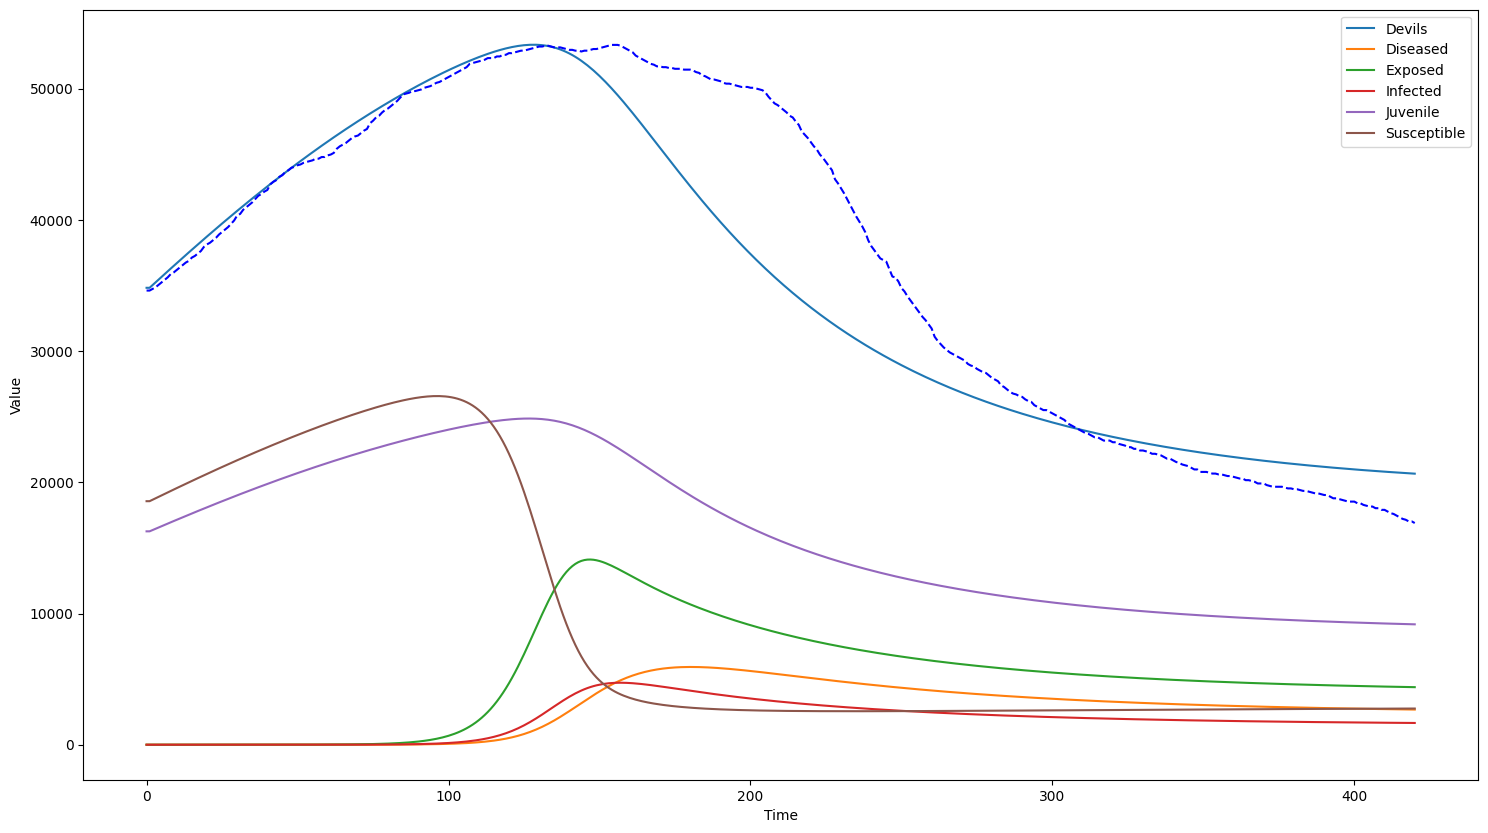

In [31]:
selected_vars = dict(zip(parameter_names, np.exp(posterior[best_index])))
# selected_vars = dict(zip(parameter_names, posterior[0]))
print(selected_vars)
test = model.run(with_pr=True, variables = selected_vars)
test.plot()
plt.plot(model.tspan, devil_pop, '--b')